In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd

In [33]:
import datetime as dt
# from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [35]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()


In [36]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

##### ---- not sure if I need this
Base.metadata.create_all(conn)


In [37]:
# We can view all of the classes that automap found
for x in Base.classes:
    print(x)
Base.classes.keys()

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


['measurement', 'station']

In [38]:
# Save references to each table
mt = Base.classes.measurement
st = Base.classes.station

In [39]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [40]:
inspector=inspect(engine)

# # ##--------------------------------------------
m_columns=inspector.get_columns('measurement')

s_columns=inspector.get_columns('station')

print("measurement")
for m in m_columns:
    print(m)
    # print(m['name'],m['type'])
print('-----')
print("station")
for s in s_columns:
    print(s)
    # print(s['name'],s['type'])
# # ##--------------------------------------------


# ## just printing off a few dates so i can figure out the date format
# xxx = session.query(mt)
# counter = 0
# for t in xxx:
#     print(t.date)
#     print(type(t.date))
#     counter += 1
#     if counter == 5:
#         break
# print("------------------------------------")
# the_first_date = session.query(mt.date).first()

# print(the_first_date)
# print(type(the_first_date))
# the_first_date



measurement
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
-----
station
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, '

In [41]:
# test=engine.execute("SELECT * FROM measurement WHERE station in (SELECT station from station WHERE name like '%Honolulu%' )").fetchall()
# print(len(test))


hon_sta_id=engine.execute("SELECT station from station WHERE name like '%Honolulu%'").fetchall()[0][0]


# Exploratory Climate Analysis

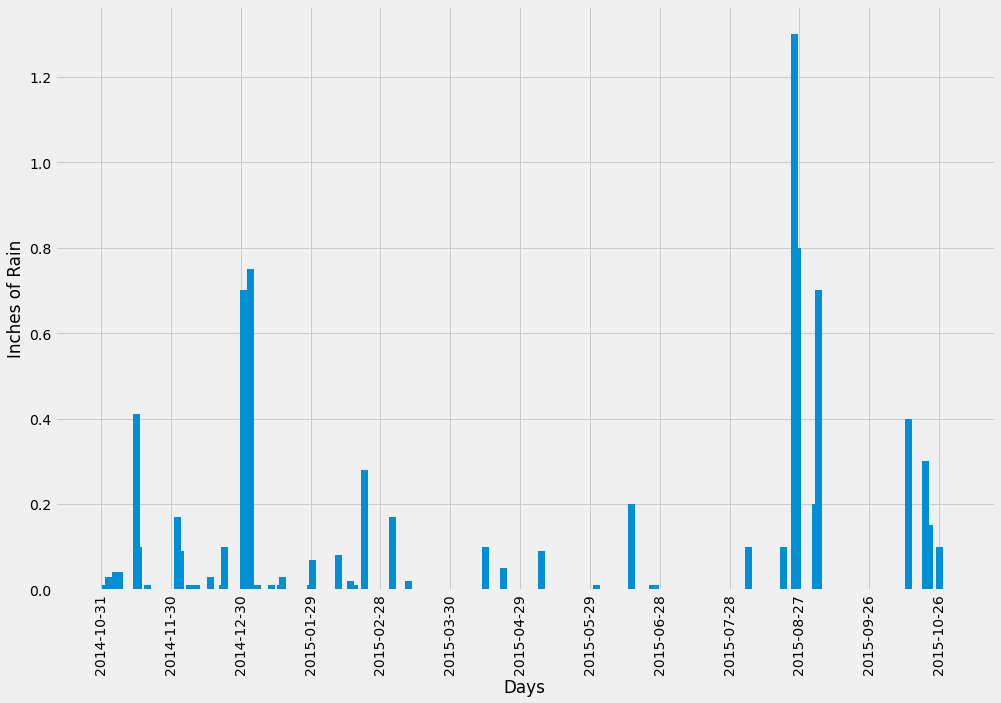

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

####getting the max day from the measurement table and converting it into datetime format
max_date = session.query(func.max(mt.date)).filter(mt.station==hon_sta_id).first()[0]
max_date = dt.datetime.strptime(max_date,'%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
year_ago =(max_date - dt.timedelta(weeks=52)).replace(day=max_date.day)

##### converting it into a format that we're able to query with
year_ago = f'{year_ago.year}-{year_ago.month:02d}-{year_ago.day:02d}'



# Perform a query to retrieve the data and precipitation scores
annual_pre_list = session.query(mt.date,mt.prcp).filter(mt.station==hon_sta_id,mt.date>year_ago).all()


year_list =[pd.to_datetime(x,format='%Y-%m-%d') for x,y in annual_pre_list]
precip_list = [y for x,y in annual_pre_list]
# print(type(year_list[0]))

# Save the query results as a Pandas DataFrame and set the index to the date column &  Sort the dataframe by date, and remove null values
annual_pre_df = pd.DataFrame({"precipitation":precip_list},index=year_list).sort_index().dropna()
# # Use Pandas Plotting with Matplotlib to plot the data

#### defining x ticks as every 30 days
x_ticks=[annual_pre_df.index[0]]
for x in range(12):
    new_date = x_ticks[-1] + dt.timedelta(days=30)
    x_ticks.append(new_date)



plt.figure(figsize=(15,10))
plt.bar(annual_pre_df.index,annual_pre_df.precipitation,width=3)
plt.xticks(x_ticks,rotation='vertical')
plt.xlabel("Days")
plt.ylabel("Inches of Rain")
plt.show()


In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
annual_pre_df.describe()

,precipitation
count,211.000000
mean,0.037346
std,0.143658
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.300000


In [44]:
# Design a query to show how many stations are available in this dataset?
station_count = engine.execute("SELECT COUNT(station.id) FROM station").fetchall()[0][0]
print(f'There are {station_count} stations in the dataset')

There are 9 stations in the dataset


In [50]:
# What are the most active stations? (i.e. what stations have the most rows)?
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


station_activity_list = engine.execute("SELECT DISTINCT station, (SELECT COUNT(measurement.id) FROM measurement WHERE measurement.station=station.station) as meas_count,(SELECT MAX(measurement.tobs) FROM measurement WHERE measurement.station=station.station) as max_temp,(SELECT MIN(measurement.tobs)FROM measurement WHERE measurement.station=station.station) as min_temp,ROUND((SELECT AVG(measurement.tobs)FROM measurement WHERE measurement.station=station.station),2) as avg_temp, name FROM station ORDER BY meas_count DESC").fetchall()


station_summary_df=pd.DataFrame(station_activity_list,columns=['station','measurement_count','max_temp','min_temp','avg_temp','name'])



# List the stations and the counts in descending order.
print(f'There are {station_count} stations in the dataset. {station_summary_df["name"][0]} is the most active station with {station_summary_df["measurement_count"][0]} measurements recorded')
station_summary_df


There are 9 stations in the dataset. WAIHEE 837.5, HI US is the most active station with 2772 measurements recorded


,station,measurement_count,max_temp,min_temp,avg_temp,name
0,USC00519281,2772,85.0,54.0,71.66,"WAIHEE 837.5, HI US"
1,USC00519397,2724,87.0,56.0,74.55,"WAIKIKI 717.2, HI US"
2,USC00513117,2709,85.0,59.0,72.69,"KANEOHE 838.1, HI US"
3,USC00519523,2669,85.0,56.0,74.54,"WAIMANALO EXPERIMENTAL FARM, HI US"
4,USC00516128,2612,84.0,58.0,70.92,"MANOA LYON ARBO 785.2, HI US"
5,USC00514830,2202,85.0,58.0,74.87,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
6,USC00511918,1979,87.0,53.0,71.62,"HONOLULU OBSERVATORY 702.2, HI US"
7,USC00517948,1372,87.0,58.0,74.68,"PEARL CITY, HI US"
8,USC00518838,511,83.0,58.0,72.72,"UPPER WAHIAWA 874.3, HI US"


351
351


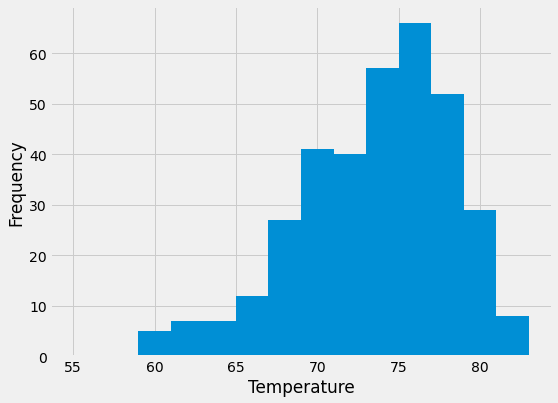

In [108]:
# Choose the station with the highest number of temperature observations.
top_station=station_summary_df["station"][0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

### find the first and last date we'll be plotting 
top_last_date = dt.datetime.strptime(session.query(mt.date,mt.tobs).order_by(mt.date.desc()).first()[0],'%Y-%m-%d')
top_first_date = top_last_date - dt.timedelta(days=365)


##### using the first and last date for the top station, query the temp data

top_station_temps_df=pd.DataFrame(session.query(mt.date,mt.tobs).filter(mt.station==top_station,mt.date>top_first_date).all())
###making the date he index
top_station_temps_df.set_index('date',inplace=True)


print(len(top_station_temps_df))
top_station_temps_df.dropna(inplace=True)



bin=np.arange(55,85,2)
bin
print(len(top_station_temps_df))
fig,ax=plt.subplots(figsize=(8,6))
ax.hist(top_station_temps.tobs,bins=bin)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()


## Bonus Challenge Assignment

In [ ]:
# # This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# # and return the minimum, average, and maximum temperatures for that range of dates
# def calc_temps(start_date, end_date):
#     """TMIN, TAVG, and TMAX for a list of dates.
    
#     Args:
#         start_date (string): A date string in the format %Y-%m-%d
#         end_date (string): A date string in the format %Y-%m-%d
        
#     Returns:
#         TMIN, TAVE, and TMAX
#     """
    
#     return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
#         filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# # function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# # Create a query that will calculate the daily normals 
# # (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

# def daily_normals(date):
#     """Daily Normals.
    
#     Args:
#         date (str): A date string in the format '%m-%d'
        
#     Returns:
#         A list of tuples containing the daily normals, tmin, tavg, and tmax
    
#     """
    
#     sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
#     return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
# daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
